# Using ML for paramter estimation

In [1]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model
from scipy.optimize import minimize
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV


"""Loading the Data"""

dir       = 'data/'
file_name = 'grid1_zheb51fo.xlsx'
UX1       = pd.read_excel(dir+file_name, sheet_name='UX1_Index')
UX2       = pd.read_excel(dir+file_name, sheet_name='UX2_Index')
UX1       = UX1.set_index('Date')
UX2       = UX2.set_index('Date')
UX1.dropna(subset = ["PX_LAST"], inplace=True)   #Getting rid of NaN values
UX2.dropna(subset = ["PX_LAST"], inplace=True)
UX1.sort_index(inplace=True)
UX2.sort_index(inplace=True)
dataset = np.array(UX1.PX_LAST)

In [150]:
"""Specifying the Input & Output (Labels)"""

n=5     #Looking at n previous days to estimate paramteres + today's volatility
X= [[dataset[j] for j in range(i, i+n+1)] for i in range(len(dataset) - n - 1)]
Y= [dataset[i+n+1] for i in range(len(dataset) - n -1)]

# Putting more emphasis on today's data:

emphasis = 3    #repearing today's value emphasis times
for i in range(len(X)):
    for j in range(emphasis-1):
        X[i].append(X[i][-1])        
        
# print(X[:10])
# print("\n")
# print(Y[:10])

[[24.85, 24.45, 23.55, 23.15, 22.55, 22.25, 22.25, 22.25], [24.45, 23.55, 23.15, 22.55, 22.25, 22.8, 22.8, 22.8], [23.55, 23.15, 22.55, 22.25, 22.8, 22.5, 22.5, 22.5], [23.15, 22.55, 22.25, 22.8, 22.5, 22.0, 22.0, 22.0], [22.55, 22.25, 22.8, 22.5, 22.0, 22.55, 22.55, 22.55], [22.25, 22.8, 22.5, 22.0, 22.55, 21.55, 21.55, 21.55], [22.8, 22.5, 22.0, 22.55, 21.55, 21.4, 21.4, 21.4], [22.5, 22.0, 22.55, 21.55, 21.4, 22.65, 22.65, 22.65], [22.0, 22.55, 21.55, 21.4, 22.65, 24.75, 24.75, 24.75], [22.55, 21.55, 21.4, 22.65, 24.75, 24.35, 24.35, 24.35]]


[22.8, 22.5, 22.0, 22.55, 21.55, 21.4, 22.65, 24.75, 24.35, 24.55]


In [3]:
"""Splitting Data into Train and Test set"""

m_training= 2000
m_test= 1000

X_training=X[:m_training]
Y_training=Y[:m_training]   
X_test=X[m_training:m_training+m_test]
Y_test=Y[m_training:m_training+m_test]

if n==0:
    X_training= np.ravel(X_training)  
    X_test    = np.ravel(X_test)

In [4]:
"""Building the Hypothesis"""

def heston_pde_milstein(V0, k, theta, rho, sigma):
    WT  = np.sqrt( 1 ) * np.random.multivariate_normal(np.array([0, 0]), np.array([[1, rho], [rho, 1]]))[1]
    V1 = np.abs(V0+ k * (theta - V0) * 1 + sigma * np.sqrt(V0) * WT + .25 * sigma**2 * (WT**2 - 1))
    return V1

In [5]:
"""Building the Loss Function"""

#The difference between real label and the predicted one to the power of 2
#l = (heston_pde_milstein(X_training[i], r, k, theta, rho, sigma) - Y_training[i])**2

m=len(X_training)  #Training set size
# k: x[0], theta:x[1], rho:x[2], sigma:x[3]

def Ls(X):
    def heston_inner_func(i):   #calculates the predicted lable for each training sample
        WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[2]], [X[2], 1]]))[1]
        V1 =  np.abs(X_training[i] + X[0] * (X[0] - X_training[i]) * 1 + 
                     X[3] * np.sqrt(X_training[i]) * WT + .25 * X[3]**2 * (WT**2 - 1))
        return V1
    Ls = (1/m) * np.sum(np.array([(heston_inner_func(i) - Y_training[i])**2 for i in range(m)]))
    return Ls

In [6]:
"""ERM: Empirical Risk Minimization"""

result = minimize(Ls, (1,1,1,1))  #initial values should be given

In [7]:
best_params = result.x
print("Best Paramteres:", best_params)
print("Minimum Ls:", result.fun)

Best Paramteres: [1. 1. 1. 1.]
Minimum Ls: 771.5985470441819


In [8]:
#Are we trapped inside a loval minima?!!

In [9]:
"""Evaluating the model on test Set"""

k, theta, rho, sigma = best_params[0], best_params[1], best_params[2], best_params[3]
Y_pred = np.array([heston_pde_milstein(X_test[i], k, theta, rho, sigma) for i in range(len(X_test))])
Y_pred = np.ravel(Y_pred)

#True Error
Ld =  (1/len(Y_test)) * np.sum((Y_pred - Y_test)**2)
print(Ld)

ValueError: operands could not be broadcast together with shapes (3000,) (1000,) 

In [ ]:
Y_pred_train = np.array([heston_pde_milstein(X_training[i], k, theta, rho, sigma) for i in range(len(X_training))])
L =  (1/m) * np.sum((Y_pred_train - Y_training)**2)
print(L)

print(Y_pred_train[:50])
print(Y_training[:50])

In [151]:
"""Using Neural Network for the Whole task: A Non-Physical Experiment"""

#Let's, just for a momemnt, Ignore any pre_knowledge about the subject and see what happens

m_training= 2000
m_test= 1000

X_training=X[:m_training]
Y_training=Y[:m_training]   
X_test=X[m_training:m_training+m_test]
Y_test=Y[m_training:m_training+m_test]

if n==0:
    X_training= np.ravel(X_training)  
    X_test    = np.ravel(X_test)
    
#Let's scale the Volatilities:
M = 100    #M times magnification

X_training= np.array(X_training) * M
Y_training= np.array(Y_training) * M
X_test= np.array(X_test) * M
Y_test= np.array(Y_test) * M

In [152]:
NN_R = MLPRegressor(hidden_layer_sizes=(20, 20, 20, 20), max_iter=1000, 
                    alpha=1e-4, solver='adam', momentum=0.9,
                    activation='relu', tol=1e-4, learning_rate_init=0.001)

NN_R.fit(X_training, Y_training)
Y_pred = NN_R.predict(X_test)
# print("Predicted Volatilty:\n", Y_pred[100:120])
# print("\nTrue Volatility:\n",     Y_test[100:120])
print("\nThe score:", NN_R.score(X_test, Y_test))


The score: 0.953913316333519


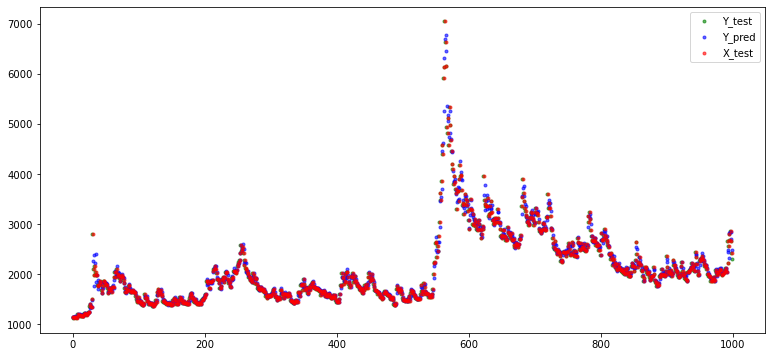

In [155]:
#at this point we don't know if we are getting a good score just beacuse of the similarity between volatlities or
#the model is working properly, we should try to figure out a way to find this!
#let's plot the graphs and see what's going on

plt.figure(figsize=(13,6))
plt.scatter([t for t in range(len(Y_test))], Y_test, alpha= 0.6,color='g', marker='.', label='Y_test')
plt.scatter([t for t in range(len(Y_test))], Y_pred, alpha= 0.6,color='b', marker='.', label='Y_pred')
plt.scatter([t for t in range(len(Y_test))], 
            [X_test[i][-1] for i in range(len(Y_test))],alpha= 0.6, color='r', marker='.', label='X_test')
# plt.xlim(550,600)
# plt.ylim(3000,5000)
plt.legend()

Distance to Today:
 89012.75739418346

Distance to Tommorow:
 81139.13999999998


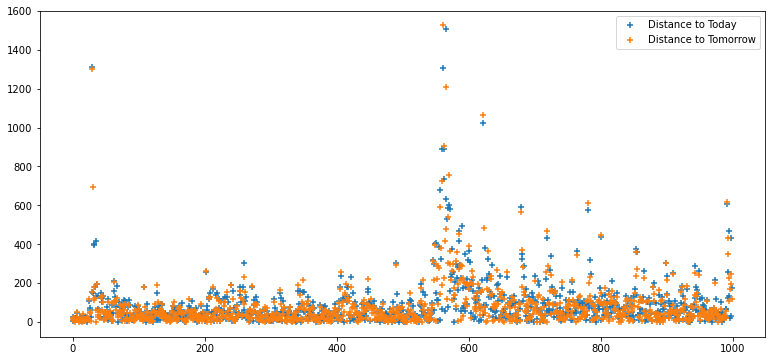

In [156]:
#It seems that the result is merely a translation of today's volalitilies not the predictions for tomorrow!
#but let's measure this preciesly

Distance_from_today    = np.abs(np.array(Y_pred) - np.array(Y_test))
Distance_from_tomorrow = np.abs(np.array([X_test[i][-1] for i in range(len(Y_test))] - np.array(Y_test)))

plt.figure(figsize=(13,6))
plt.scatter([t for t in range(len(Y_pred))], Distance_from_today, marker = '+', label = 'Distance to Today')
plt.scatter([t for t in range(len(Y_pred))], Distance_from_tomorrow, marker = '+', label = 'Distance to Tomorrow')
# plt.xlim(100,140)
# plt.ylim(-0.5,1)
plt.legend()

print("Distance to Today:\n", np.sum(Distance_from_today))
print("\nDistance to Tommorow:\n", np.sum(Distance_from_tomorrow))

In [176]:
#Let's Investigate the behaviour of Distance w.r to n (Looking at n previous data)

Distance_from_today_list    = []
Distance_from_tomorrow_list = []
for n in range(0,100,3):
    
    X= [[dataset[j] for j in range(i, i+n+1)] for i in range(len(dataset) - n - 1)]
    Y= [dataset[i+n+1] for i in range(len(dataset) - n -1)]

    emphasis = 3    #repearing today's value emphasis times
    for i in range(len(X)):
        for j in range(emphasis-1):
            X[i].append(X[i][-1])    
            
    m_training= 2000
    m_test= 1000
    X_training=X[:m_training]
    Y_training=Y[:m_training]   
    X_test=X[m_training:m_training+m_test]
    Y_test=Y[m_training:m_training+m_test]
    
#     if n==0:
#         X_training= np.ravel(X_training)  
#         X_test    = np.ravel(X_test)
        
    M = 100    #M times magnification
    X_training= np.array(X_training) * M
    Y_training= np.array(Y_training) * M
    X_test= np.array(X_test) * M
    Y_test= np.array(Y_test) * M
    
    NN_R = MLPRegressor(hidden_layer_sizes=(20, 20, 20, 20), max_iter=1000, 
                    alpha=1e-4, solver='adam', momentum=0.9,
                    activation='relu', tol=1e-4, learning_rate_init=0.001)
    NN_R.fit(X_training, Y_training)
    Y_pred = NN_R.predict(X_test)
    
    Distance_from_today    = np.sum(np.abs(Y_pred - Y_test))
    Distance_from_tomorrow = np.sum(np.abs(np.array([X_test[i][-1] for i in range(len(list(Y_test)))]) - Y_test))
    
    Distance_from_today_list.append(Distance_from_today)
    Distance_from_tomorrow_list.append(Distance_from_tomorrow)

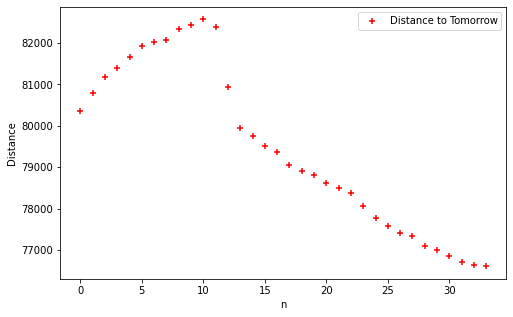

In [177]:
# Plotting the Result of previous part

L = len(Distance_from_today_list)
plt.figure(figsize=(8,5))
# plt.plot([t for t in range(L)], Distance_from_today_list, )
plt.scatter([t for t in range(L)], Distance_from_tomorrow_list,
            marker="+",color='r', label = 'Distance to Tomorrow')
plt.xlabel('n')
plt.ylabel('Distance')
plt.legend()

In [ ]:
#A weird bahviour at n=10!!!
#Let's investigate that part!:
#Correct X axis

In [ ]:
# Model Selection, Grid Search CV
NN_R = MLPRegressor(max_iter=1000, alpha=1e-4, solver='adam', momentum=0.9,
                    activation='relu', tol=1e-4, learning_rate_init=0.001)
parameters = {'hidden_layer_sizes': [(20),(20,20),(20,20,20),(20,20,20,20),(20,20,20,20,20)]}

gsc = GridSearchCV(NN_R, parameters, cv=5)

gsc.fit(X_training, Y_training)

In [26]:
print("Best parameters set found:")
print(gsc.best_params_)
print("\n")

print("Score with best parameters:")
print(gsc.best_score_)
print("\n")

print("All scores on the grid:")
print(gsc.cv_results_.get('split0_test_score'))
print(gsc.cv_results_.get('split1_test_score'))
print(gsc.cv_results_.get('split2_test_score'))
print(gsc.cv_results_.get('split3_test_score'))
print(gsc.cv_results_.get('split4_test_score'))
print(gsc.cv_results_.get('split5_test_score'))

Best parameters set found:
{'hidden_layer_sizes': (20, 20, 20, 20, 20)}


Score with best parameters:
0.90488569959342


All scores on the grid:
[0.94097903 0.93916745 0.93914332 0.941293   0.94069924]
[0.96063457 0.95935932 0.95822836 0.96016939 0.96022955]
[0.83770584 0.8383946  0.83515761 0.83133145 0.83605076]
[0.89504264 0.89384032 0.88486489 0.89373389 0.89492555]
[0.88376219 0.89331355 0.88951837 0.88771578 0.89252339]
None
